In [ ]:
import numpy as np
import torch
import torch.nn as nn
import zipfile
import pandas as pd
import glob
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
with zipfile.ZipFile("/content/drive/MyDrive/isic-2024-challenge.zip") as z:
    with z.open("train-metadata.csv") as f:
        train_df = pd.read_csv(f)
    with z.open("test-metadata.csv") as f:
        test_df = pd.read_csv(f)

all_df = pd.concat([train_df, test_df]).reset_index(drop=True)
display(train_df.head())
display(test_df.head())

<ipython-input-5-256475a818c6>:3: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(f)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [ ]:
df = train_df.copy()
print(f"Number of images: {df.shape[0]}, number of positive cases: {df.target.sum()}, number of negative cases: {(df['target'] == 0).sum()}, number of patients: {df['patient_id'].nunique()}")
df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

Number of images: 401059, number of positive cases: 393, number of negative cases: 400666, number of patients: 1042


Note that number of images is less than number of patients, which means one patient could have multiple pictures.


EDA

In [ ]:
print(df.columns)

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

To see five patients' information

In [ ]:
 df.T.sample(n=5, axis=1)

,10402,161222,375913,249856,43001
isic_id,ISIC_0330519,ISIC_4070622,ISIC_9376234,ISIC_6278321,ISIC_1133278
target,0,0,0,0,0
patient_id,IP_2465915,IP_5299455,IP_3930863,IP_1117889,IP_1930850
age_approx,40.0,60.0,35.0,55.0,60.0
sex,male,female,female,female,male
anatom_site_general,lower extremity,upper extremity,lower extremity,posterior torso,upper extremity
clin_size_long_diam_mm,3.5,2.76,2.74,3.29,3.0
image_type,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up
tbp_tile_type,3D: XP,3D: XP,3D: white,3D: XP,3D: XP
tbp_lv_A,21.333193,24.21891,16.014032,19.294455,17.135776


 Checking NaN values 

In [ ]:
df.isna().sum()

,0
isic_id,0
target,0
patient_id,0
age_approx,2798
sex,11517
anatom_site_general,5756
clin_size_long_diam_mm,0
image_type,0
tbp_tile_type,0
tbp_lv_A,0


we can see that majority of idd_2, iddx_3,iddx_4,iddx_4, iddx_5, mel_motiotic_index,mel_thick_mm are none, therefore we can drop these columns
as well as some other columns 


In [ ]:
def drop_columns(df):
    columns = ['isic_id','copyright_license', 'attribution', 'image_type', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4',
               'iddx_5', 'iddx_full', 'mel_mitotic_index', 'mel_thick_mm', 'tbp_tile_type', 'tbp_lv_dnn_lesion_confidence',
               'lesion_id']

    for column in columns:
        try:
            df.drop(column, axis=1, inplace=True)
        except KeyError as e:
            print('No column with name', e)

    return df

In [ ]:
df_new=drop_columns(df)

No column with name "['isic_id'] not found in axis"
No column with name "['copyright_license'] not found in axis"
No column with name "['attribution'] not found in axis"
No column with name "['image_type'] not found in axis"
No column with name "['iddx_1'] not found in axis"
No column with name "['iddx_2'] not found in axis"
No column with name "['iddx_3'] not found in axis"
No column with name "['iddx_4'] not found in axis"
No column with name "['iddx_5'] not found in axis"
No column with name "['iddx_full'] not found in axis"
No column with name "['mel_mitotic_index'] not found in axis"
No column with name "['mel_thick_mm'] not found in axis"
No column with name "['tbp_tile_type'] not found in axis"
No column with name "['tbp_lv_dnn_lesion_confidence'] not found in axis"
No column with name "['lesion_id'] not found in axis"


Filling Na with the modes 

In [ ]:
df_new.isna().sum()
#we can repalce NA values with mode
modes=df.mode().iloc[0]
df_new.fillna(modes, inplace=True)

Next, we would like to seperate all the variables as continuous variables and categorical variables


In [ ]:
cat_df=['patient_id','target','age_approx','sex','anatom_site_general','tbp_lv_location','tbp_lv_location_simple']
con_df=[x for x in df_new.columns if x not in cat_df]
for col in cat_df:
  df_new[col]=df_new[col].astype('category').cat.codes


Next we proceed with the Random forest 


In [ ]:
from numpy import random
from sklearn.model_selection import train_test_split
X = df_new.drop(columns=['target'])
y = df_new['target']
X_train, X_test,y_train, y_test = train_test_split (X,y,test_size=0.25,shuffle=True, stratify=df_new['target'])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

rf = RandomForestClassifier(100, min_samples_leaf=5)
print(X_train.shape)
print(y_train.shape)
rf.fit(X_train,y_train)

(300794, 39)
(300794,)


RandomForestClassifier(min_samples_leaf=5)

And use it to the the featurres importance

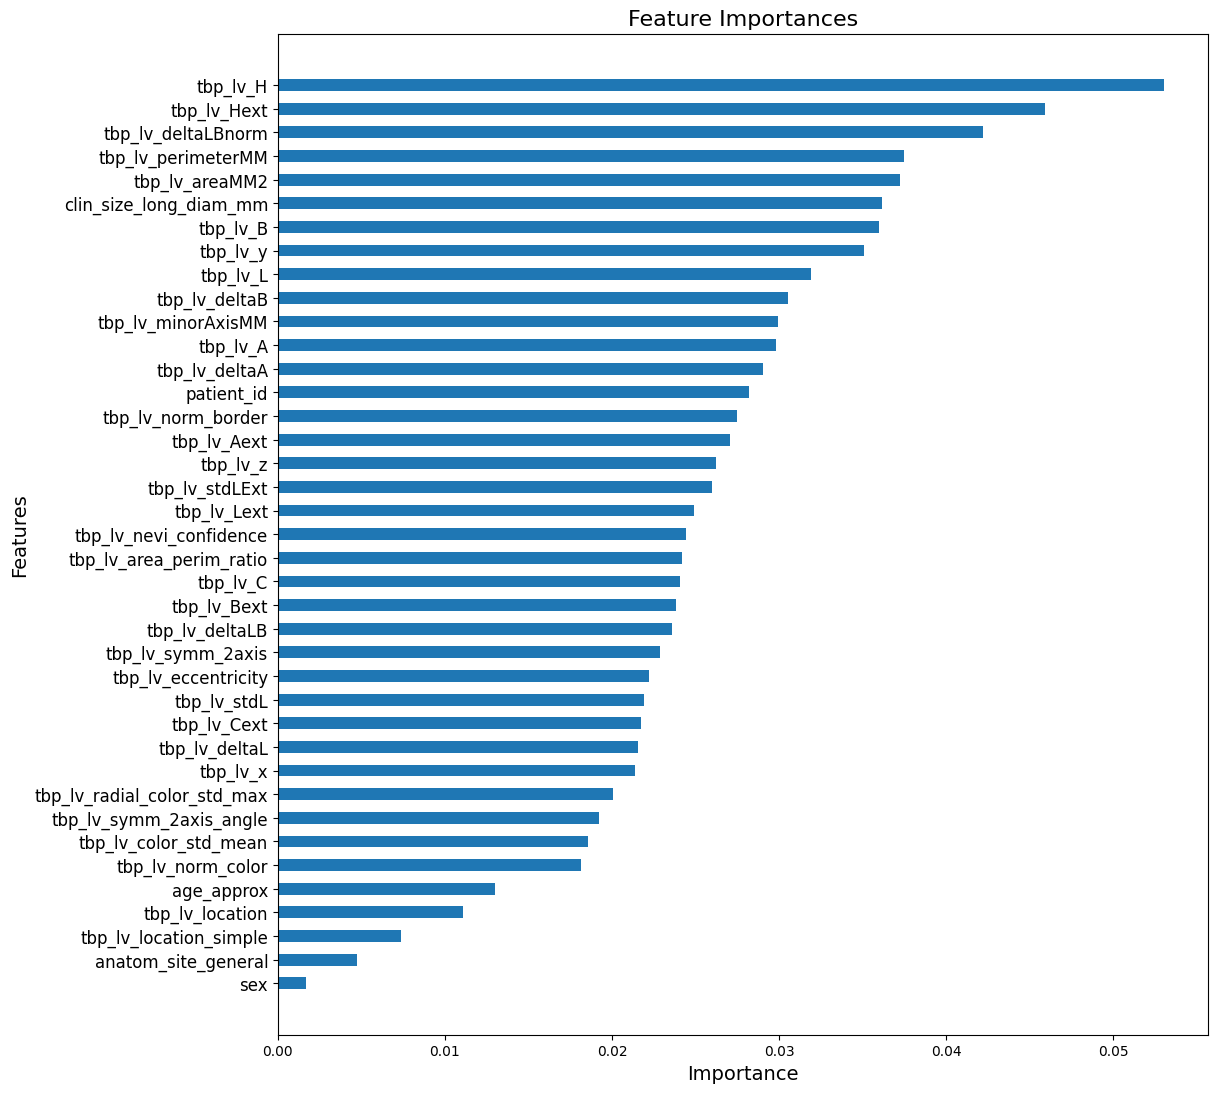

In [ ]:
import matplotlib.pyplot as plt
 
importance = rf.feature_importances_
df_imp = pd.DataFrame({'feature': X_train.columns, 'importance': importance}).sort_values('importance', ascending=True)
fig, ax = plt.subplots(figsize=(12, 13))
ax.barh(df_imp['feature'], df_imp['importance'], height=0.5)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importances', fontsize=16)
ax.tick_params(axis='y', labelsize=12)
plt.show()


But many of them are corellated 


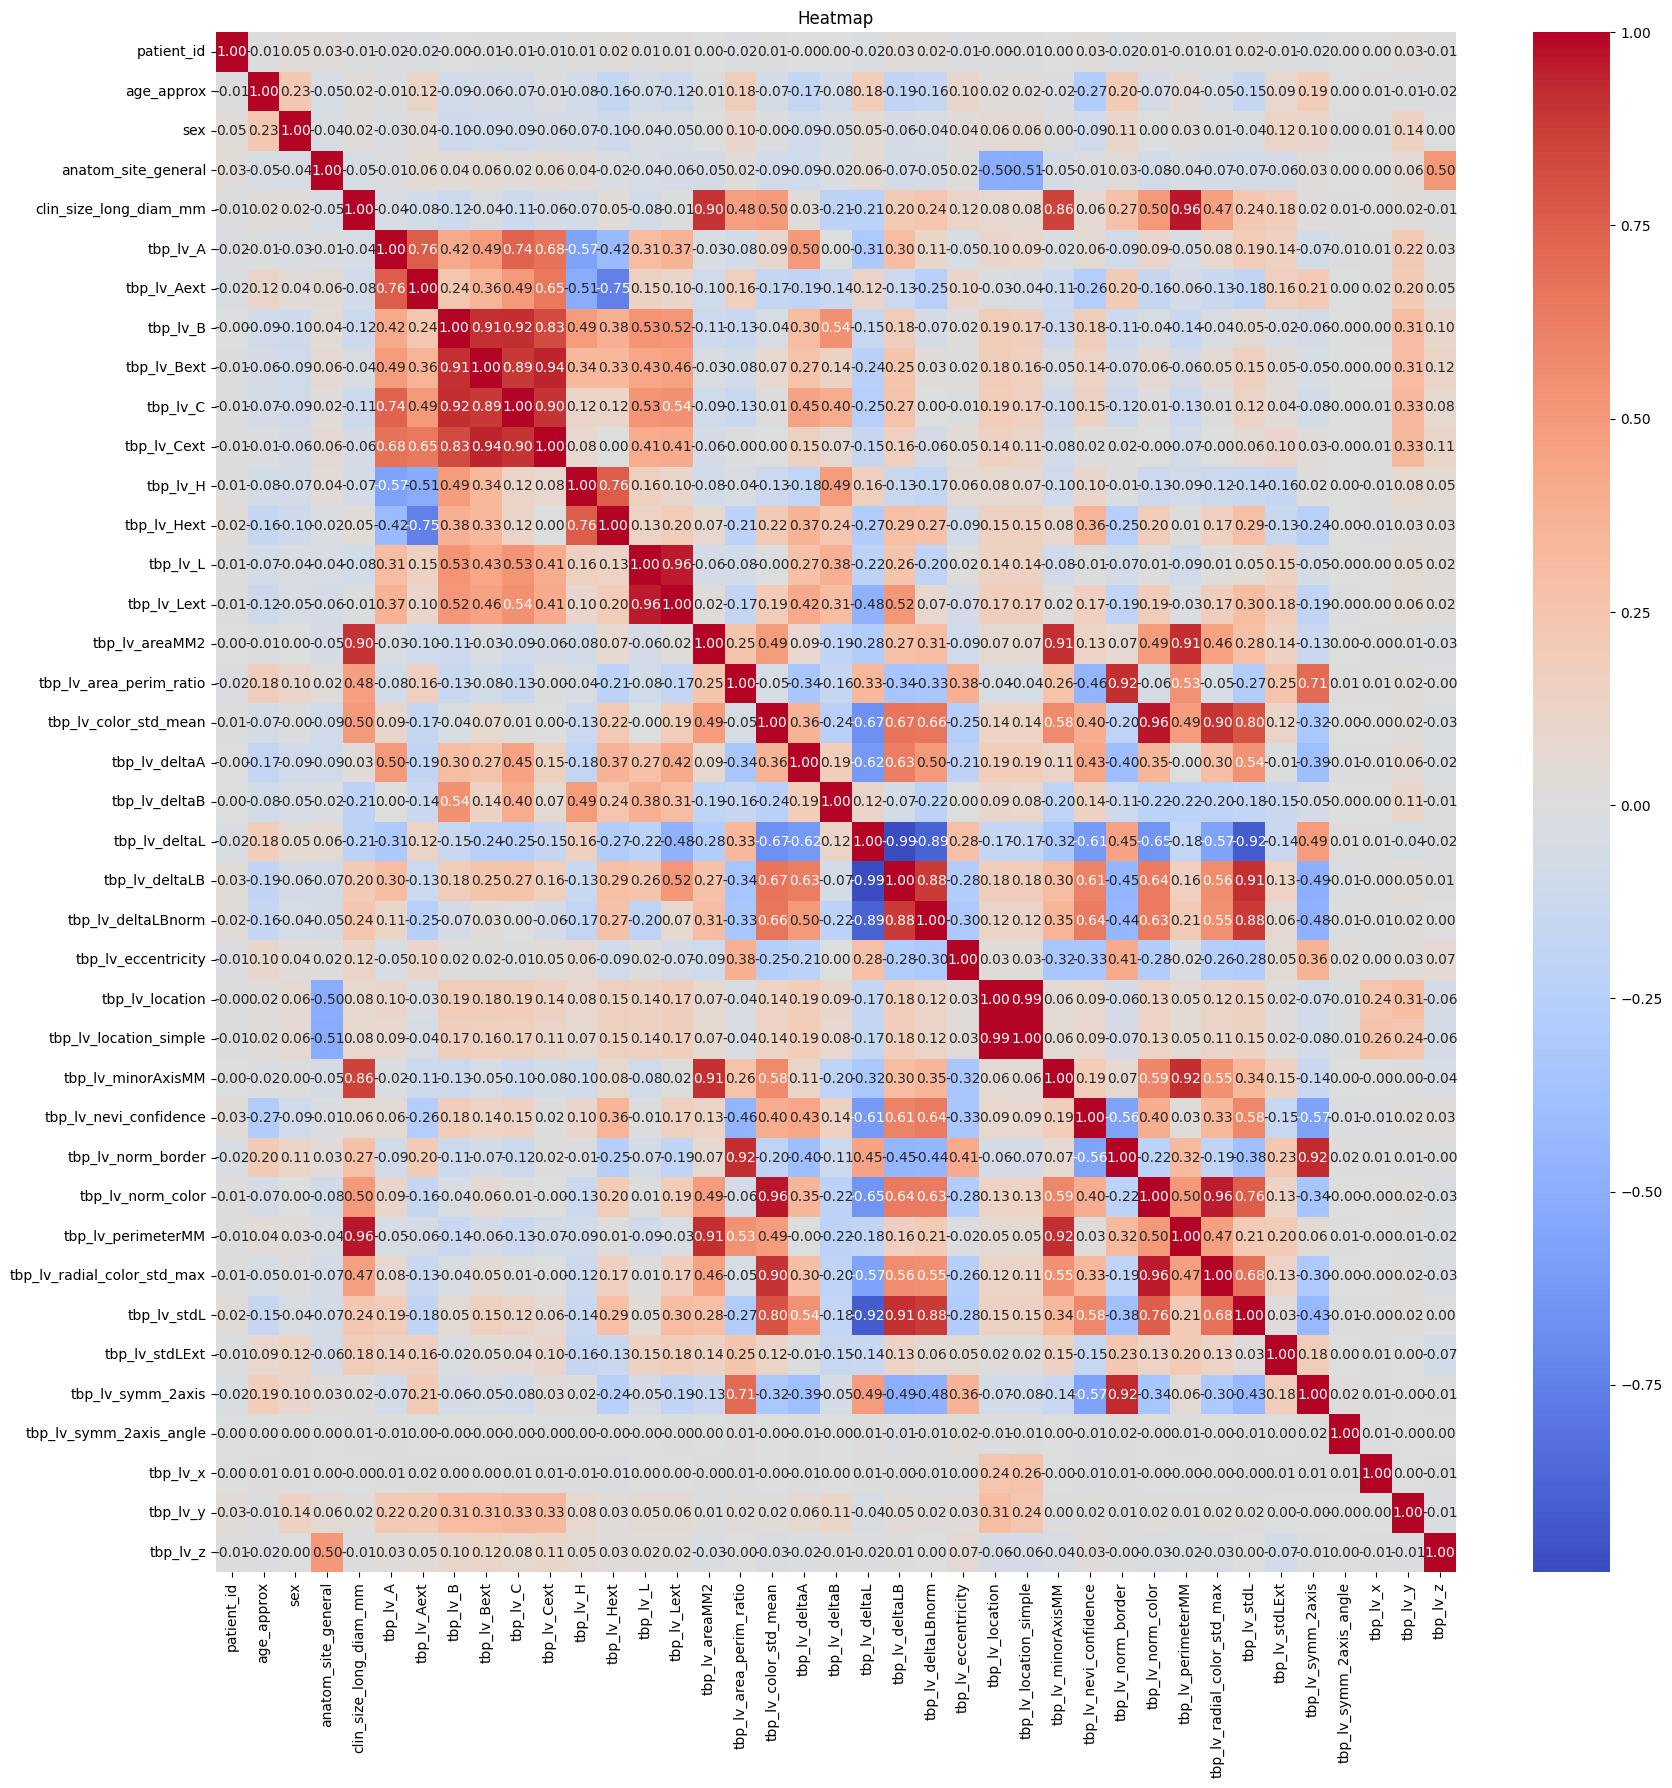

In [ ]:
import seaborn as sns
numeric_columns = X_train
plt.figure(figsize=(20, 20))
corr_matrix = numeric_columns.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', annot_kws={'size': 10},cmap='coolwarm')
plt.title('Heatmap')
plt.show()

And some violin type plots


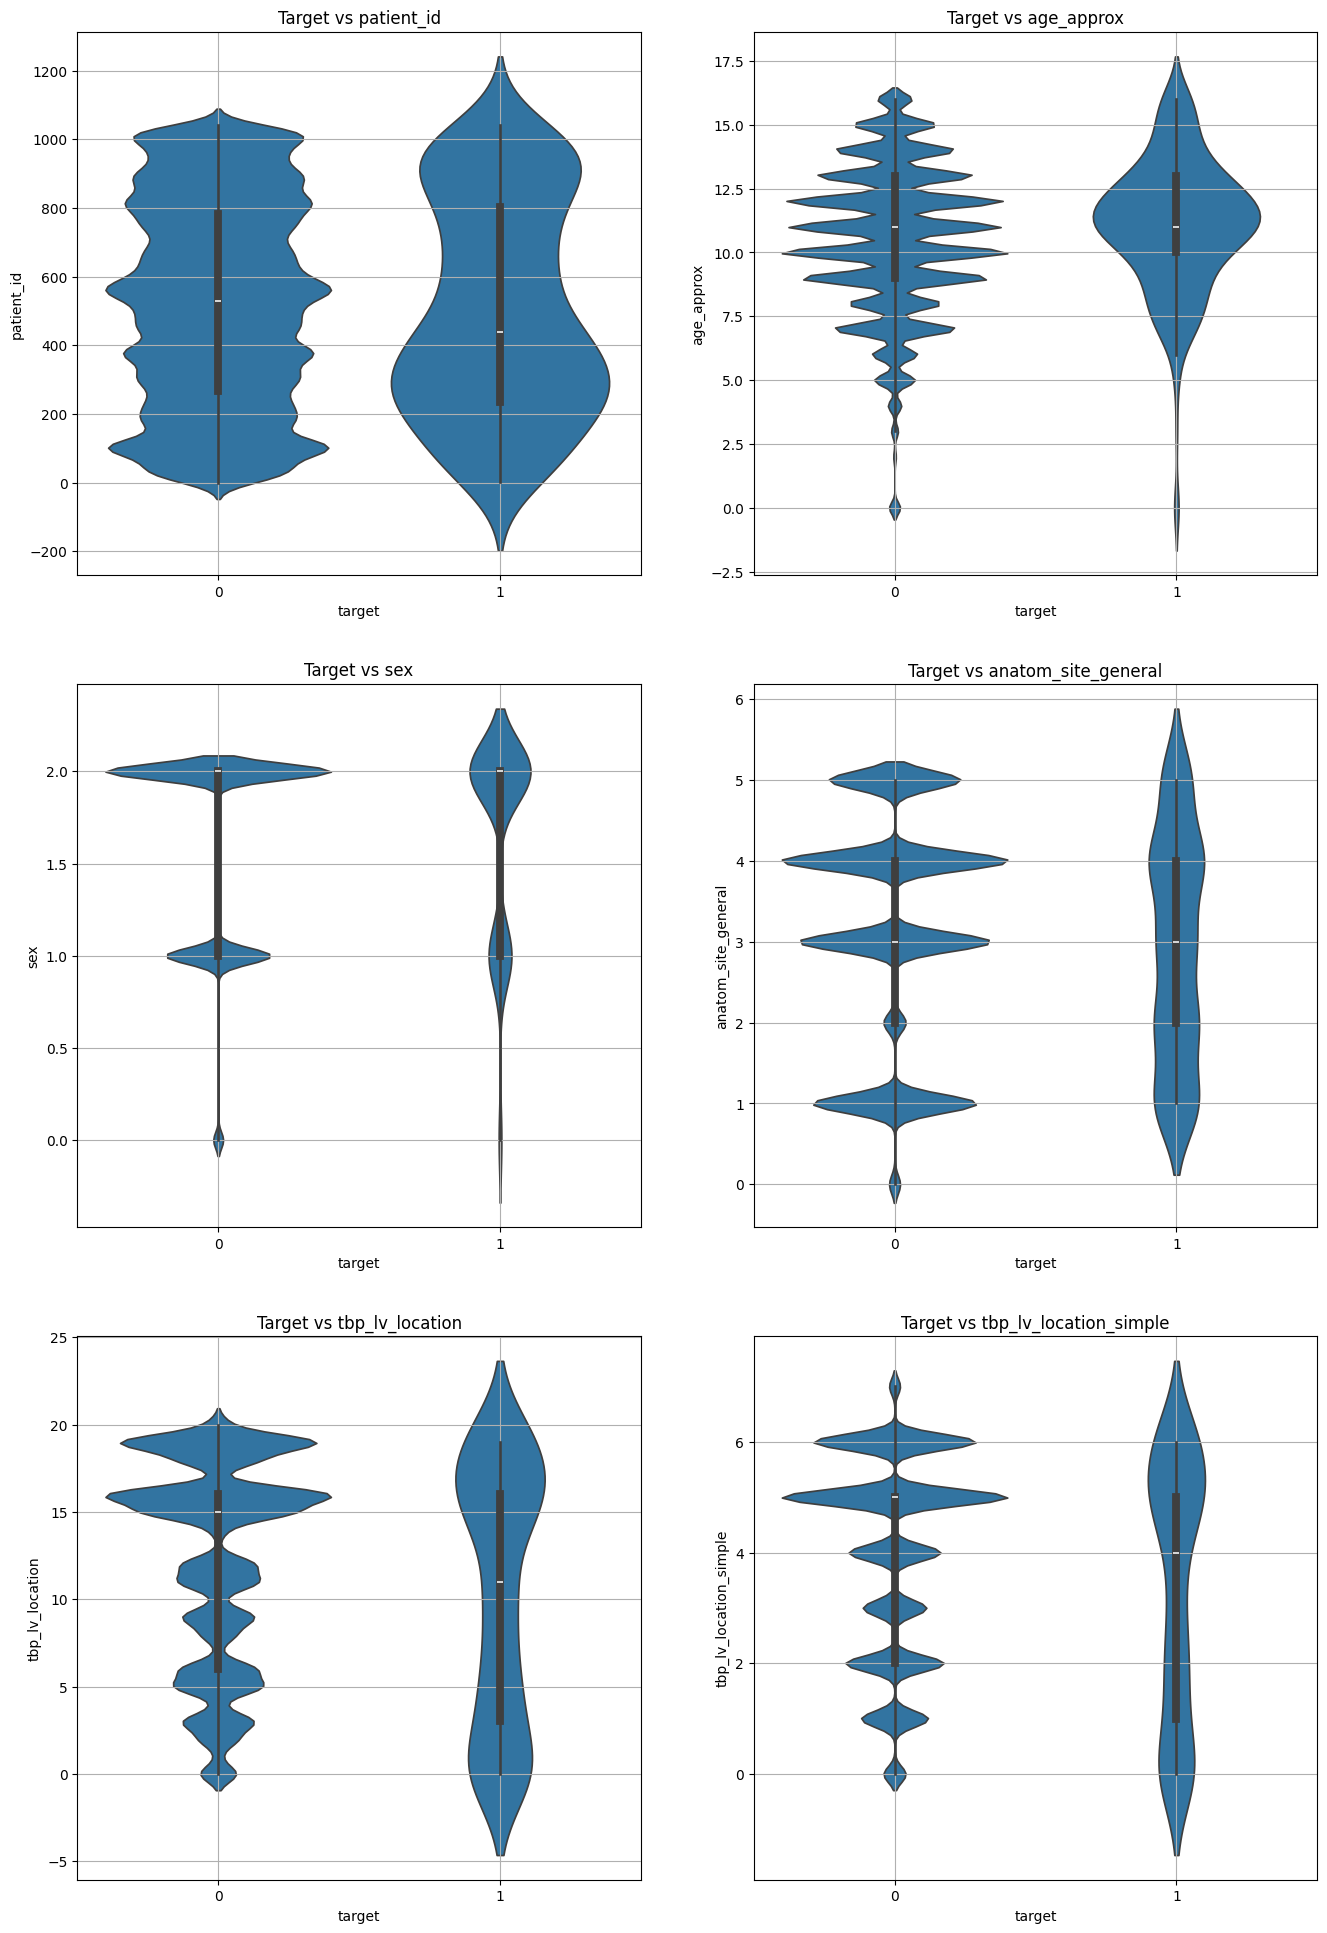

In [ ]:
# X_train y_train
df_train = pd.concat([X_train, y_train], axis=1)
cat_df=['patient_id','age_approx','sex','anatom_site_general','tbp_lv_location','tbp_lv_location_simple']
features=cat_df


fig, axes = plt.subplots(nrows=len(features) // 2 + len(features) % 2, ncols=2, figsize=(16, len(cat_df) * 4))


for i, f in enumerate(features):
    row = i // 2
    col = i % 2
    sns.violinplot(data=df_train, x='target', y=f, ax=axes[row, col])
    axes[row, col].set_title('Target vs ' + f)
    axes[row, col].grid()


#if len(cat_df) % 2 != 0:
 #   fig.delaxes(axes[-1, -1])

#plt.tight_layout()
#plt.show()